$$ \Large \underline
{\textbf{Problema 1}}
$$

Determine los desplazamientos de los bordes libres y los esfuerzos en función de la posición para la
placa empotrada mostrada en la figura. Tome las dos particiones en elementos mostradas debajo y
compare los resultados. Asuma que E = 30 x 10e6
 psi y n = 0.30.

<center><img src="ImgProb01bG03.png"></center>

In [1]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
import MEF as mef

In [2]:
gmsh.initialize()

In [3]:
gmsh.model.add('test_01')

In [4]:
L = 20  # in
lc = L
h = 10  # in
v = 0.3  # coef Poisson
E = np.array([30e6,30e6,30e6,30e6])  # psi
t = 1  # in

In [5]:
p1 = gmsh.model.geo.addPoint(0,0,0,2*lc)
p2 = gmsh.model.geo.addPoint(L,0,0,2*lc)
p3 = gmsh.model.geo.addPoint(L,h,0,2*lc)
p4 = gmsh.model.geo.addPoint(0,h,0,2*lc)

In [6]:
l1 = gmsh.model.geo.addLine(p1,p2)
l2 = gmsh.model.geo.addLine(p2,p3)
l3 = gmsh.model.geo.addLine(p3,p4)
l4 = gmsh.model.geo.addLine(p4,p1)

In [7]:
C1 = gmsh.model.geo.addCurveLoop([l1,l2,l3,l4])

In [8]:
S1 = gmsh.model.geo.addPlaneSurface([C1])

In [9]:
gmsh.model.geo.synchronize()

Ya están todos los elementos geométricos. 

In [10]:
Empotrado = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1,Empotrado,'Empotrado')

In [11]:
Traccionado = gmsh.model.addPhysicalGroup(1,[l2])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

In [12]:
Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie,'Superficie')

Realizo el mallado

In [13]:
gmsh.model.mesh.generate(2)  # Se genera el mallado con dimension 2. Mallado por Volronoi

In [14]:
gmsh.model.geo.synchronize()
gmsh.fltk.run()

Obtenemos la matriz de nodos

In [15]:
NodeInfo = gmsh.model.mesh.get_nodes()

In [16]:
NodeInfo

(array([1, 2, 3, 4, 5], dtype=uint64),
 array([ 0.,  0.,  0., 20.,  0.,  0., 20., 10.,  0.,  0., 10.,  0., 10.,
         5.,  0.]),
 array([], dtype=float64))

Se tienen varios arrays. El primero tiene los numeros asignados a cada nodo, desde 1 hasta 5. La asignación está en el shape [0]

El segundo array tiene las posiciones x y z de cada uno de los nodos, pero indicados unidimensionalmente, así que habrá que hacer un reshape para formar una matriz de filas y columnas. Es una fila sola actualmente, habrá que modificarla.

In [17]:
NumeroNodos = NodeInfo[0].shape[0]

In [18]:
MN = NodeInfo[1].reshape(NumeroNodos,3)

In [19]:
ElementInfo = gmsh.model.mesh.get_elements()

In [20]:
ElementInfo

(array([ 1,  2, 15]),
 [array([11,  1, 12,  2], dtype=uint64),
  array([3, 4, 5, 6], dtype=uint64),
  array([ 7,  8,  9, 10], dtype=uint64)],
 [array([1, 2, 2, 3, 3, 4, 4, 1], dtype=uint64),
  array([4, 1, 5, 2, 3, 5, 1, 2, 5, 3, 4, 5], dtype=uint64),
  array([1, 2, 3, 4], dtype=uint64)])

Los tipos de elementos (lineas, triangulos, y puntos):

In [21]:
ElementInfo[0]

array([ 1,  2, 15])

Etiquetas de los triangulos:

In [22]:
ElementInfo[1][1]

array([3, 4, 5, 6], dtype=uint64)

Matriz de conectividad de los triangulos

In [23]:
ElementInfo[2][1]

array([4, 1, 5, 2, 3, 5, 1, 2, 5, 3, 4, 5], dtype=uint64)

Una manera más simple:

In [24]:
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)

In [25]:
ETAGS

array([3, 4, 5, 6], dtype=uint64)

In [26]:
ELEMENTS

array([4, 1, 5, 2, 3, 5, 1, 2, 5, 3, 4, 5], dtype=uint64)

Como era unidimencional, hago el reshape de MC

In [27]:
MC = ELEMENTS.reshape(ETAGS.shape[0],3)

In [28]:
MC

array([[4, 1, 5],
       [2, 3, 5],
       [1, 2, 5],
       [3, 4, 5]], dtype=uint64)

In [29]:
MN

array([[ 0.,  0.,  0.],
       [20.,  0.,  0.],
       [20., 10.,  0.],
       [ 0., 10.,  0.],
       [10.,  5.,  0.]])

In [30]:
gmsh.option.setNumber("Mesh.MshFileVersion",2.2)
gmsh.write('test.msh')

In [31]:
glxn = 2
dimension_elementos = 2

In [32]:
Ne, Nnxe = MC.shape
Nn = MN.shape[0]

In [33]:
MC = MC - np.ones([Ne,Nnxe])  # resto 1 para acomodar a lenguaje python

In [34]:
K, Ke, D, B = mef.Kglobal_barra(MN, MC, E, glxn, dimension_elementos, v,t) 

In [35]:
s = np.array([0,1,6,7])
r = mef.vector_complemento(s, MN, glxn)

In [36]:
s

array([0, 1, 6, 7])

In [37]:
r

array([2, 3, 4, 5, 8, 9])

In [38]:
Us = np.array([0,0,0,0]).reshape([-1,1])
Fr = np.array([5000,0,5000,0,0,0]).reshape([-1,1])  # lb

In [39]:
F, U = mef.solve(K, r, s, Us, Fr)

In [40]:
sig = {}
d = {}
for e in range(Ne):
    nodo = MC[e,:].astype(int)
    d[e] = np.array([U[nodo[0]*glxn],U[nodo[0]*glxn+1],
                     U[nodo[1]*glxn],U[nodo[1]*glxn+1],
                     U[nodo[2]*glxn],U[nodo[2]*glxn+1]]).reshape([-1,1])
    sig[e] = D[e].dot(B[e].dot(d[e]))

In [41]:
np.set_printoptions(formatter={"float": lambda x: "%0.5f"% (x)})
print('\033[4m'+f'\nTensiones en x, y, xy de cada barra'+'\033[0m'+' [psi]:')
for e in range(Ne):
    print('\033[93m'+f'Elemento {e+1}:\n {sig[e]}'+'\033[0m')


Tensiones en x, y, xy de cada barra [psi]:
Elemento 1:
 [[1006.40683]
 [301.92205]
 [-0.00000]]
Elemento 2:
 [[993.59317]
 [-101.70849]
 [-0.00000]]
Elemento 3:
 [[1000.00000]
 [100.10678]
 [-3.20342]]
Elemento 4:
 [[1000.00000]
 [100.10678]
 [3.20342]]


In [42]:
U2D = U.reshape(Nn,glxn)
U3D = np.append(U2D,np.zeros(U2D.shape[0]).reshape([-1,1]),1)
print('\n\033[4m'+f'Desplazamientos x, y, e z de cada nodo'+'\033[0m'+' [in x 10^6]:')
for n in range(Nn):
    print('\033[93m'+f'Nodo {n+1}: {U3D[n]*1e6}'+'\033[0m')


Desplazamientos x, y, e z de cada nodo [in x 10^6]:
Nodo 1: [0.00000 0.00000 0.00000]
Nodo 2: [646.64531 66.63107 0.00000]
Nodo 3: [646.64531 -66.63107 0.00000]
Nodo 4: [0.00000 0.00000 0.00000]
Nodo 5: [305.27674 -0.00000 0.00000]


In [43]:
MNdef = MN + U3D*1e4

Text(0.5, 0, 'desplazamiento en x')

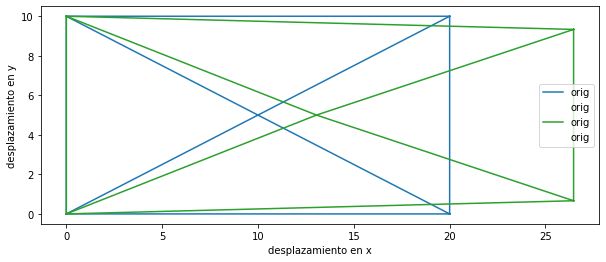

In [44]:
fig, ax = plt.subplots(figsize=(10,4))
plt.triplot(MN[:,0], MN[:,1], MC, label='orig')
plt.triplot(MNdef[:,0], MNdef[:,1], MC, label='orig')
plt.legend()
plt.ylabel('desplazamiento en y')
plt.xlabel('desplazamiento en x')